In [694]:
# define source to download
import os
import zipfile

PRIME_LIMITS = 1000000
PRIMES_ZIP_FILE_NAME = "primes1.zip"
PRIMES_EXTRACT_FILE_NAME = "primes1.txt"
PRIMES_PATH = "datasets/primes"

def extract_primes_data(primes_path=PRIMES_PATH, primes_zip_file_name=PRIMES_ZIP_FILE_NAME, primes_extract_file_name=PRIMES_EXTRACT_FILE_NAME):
    if not os.path.isdir(primes_path):
        raise Exception('Create the path: datasets/primes and copy the ' + primes_zip_file_name + ' within the path')
    zip_path = os.path.join(primes_path, primes_zip_file_name)
    if not os.path.exists(zip_path):
        raise Exception('Download primes zip from URL=https://primes.utm.edu/lists/small/millions/')
    primes_zip = zipfile.ZipFile(zip_path)
    txt_path = os.path.join(primes_path, primes_extract_file_name)
    with open(txt_path, 'w') as f:
        data = primes_zip.read(primes_extract_file_name)
        # split into line of data
        data = data.splitlines(True)
        # remove first lines due to header text type
        data = data[4:]
        new_list = []
        # filter blank lines and reduce the result to one array
        for line in data[:]:
            values = line.decode("utf-8").split()
            if len(values) > 0:
                for num in values:
                    new_list.append(num)
        text = "\n".join(new_list)
        f.write(text)
        f.close()

In [695]:
# download and extract file
extract_primes_data()

In [696]:
# define method for loading extracted data
import pandas as pd

def load_primes_data(primes_path=PRIMES_PATH, primes_extract_file_name=PRIMES_EXTRACT_FILE_NAME, limit=None):
    csv_path = os.path.join(primes_path, primes_extract_file_name)
    return pd.read_csv(csv_path, sep='\t+|\r+|\n+|\s+', nrows=limit, header=None, engine='python')

In [697]:
# load data from prepared file
primes_data = load_primes_data(limit=PRIME_LIMITS).values.flatten()
primes_data[:10]

array([ 2,  3,  5,  7, 11, 13, 17, 19, 23, 29])

In [698]:
import numpy as np

# calculate non primes data
non_primes = []
for val in range(len(primes_data)):
    non_primes.append(val)

non_primes = [x for x in non_primes if x not in primes_data]
non_primes_data = np.array(non_primes)

In [699]:
print(non_primes_data[:10])
print(non_primes_data[:-10])

[ 0  1  4  6  8  9 10 12 14 15]
[     0      1      4 ..., 999987 999988 999989]


In [700]:
# define labels for primes
y_prime = (primes_data == primes_data)
y_prime[:10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [701]:
# define lables for non-primes
y_non_prime = (non_primes_data != non_primes_data)
y_non_prime[:10]

array([False, False, False, False, False, False, False, False, False, False], dtype=bool)

In [702]:
all_numbers = np.concatenate((primes_data, non_primes_data))
all_labels = np.concatenate((y_prime, y_non_prime))

In [703]:
# compose dataset
data = {'values' : pd.Series(all_numbers),
        'labels' : pd.Series(all_labels)}
data_frame = pd.DataFrame(data)

In [704]:
data_frame.head()

,labels,values
0,True,2
1,True,3
2,True,5
3,True,7
4,True,11


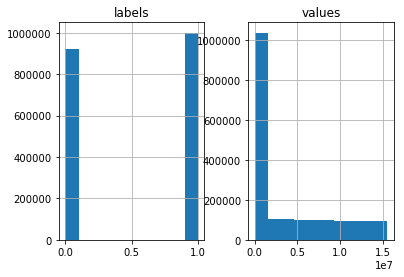

In [705]:
# plot a histogram
%matplotlib inline
import matplotlib.pyplot as plt

data_frame.hist()
plt.show()

In [706]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data_frame, data_frame["labels"]):
    train_set = data_frame.loc[train_index]
    test_set = data_frame.loc[test_index]

In [707]:
# check the stratified split
print("original data proportions\n", data_frame["labels"].value_counts() / len(data_frame))
print("stratified test proportions\n", test_set["labels"].value_counts() / len(test_set))

original data proportions
 True     0.520426
False    0.479574
Name: labels, dtype: float64
stratified test proportions
 True     0.520425
False    0.479575
Name: labels, dtype: float64


In [708]:
train_set["labels"].value_counts()

True     800000
False    737201
Name: labels, dtype: int64

In [709]:
test_set["labels"].value_counts()

True     200000
False    184301
Name: labels, dtype: int64

In [710]:
y_train = train_set["labels"]
X_train = train_set["values"].values.reshape(-1, 1)
print(X_train.shape)
print(y_train.shape)
print(X_train)
print("X_train count:", len(X_train))
print("y_train count:", len(y_train))

(1537201, 1)
(1537201,)
[[ 3380929]
 [ 6722857]
 [ 3625243]
 ..., 
 [10482533]
 [ 7169489]
 [ 4998211]]
X_train count: 1537201
y_train count: 1537201


# Train Binary Classifier

In [711]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [712]:
# cross-validation above using the cross_val_score
from sklearn.model_selection import cross_val_score
# use cross-validation k-fold = 3 and measure the accuracy in percent
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.52042638,  0.52042834,  0.52042842])

# Measuring Classifier Accuracy

In [713]:
# an good alternative instead of using the scores we can retrieve the cross-validation predictions 
# and build a confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

confusion_matrix(y_train, y_train_pred)

array([[     2, 737199],
       [     0, 800000]])

In [714]:
# to visualize the tradeoff of precision and recall we can use the decision_function instead of predict returning
# scores instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=3, method="decision_function")

# calculate values for ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

# Retrain with RandomForest Classifier

In [715]:
# we are now trying to improve the Precision/Recall using a RandomForest classifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
# some classifiers do not provide a decision_function method but a dict_proba method due to their type of 
# classification -> to use the dict_proba, we parametrize the cross_val_predict with its predict_proba parameter
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3, method="predict_proba")

# to plot a ROC curve we need to transform the prbabilities to scores
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)


In [716]:
y_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3)

confusion_matrix(y_train, y_train_pred)

array([[690527,  46674],
       [ 61987, 738013]])

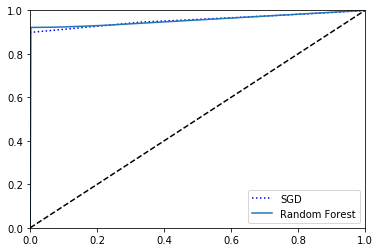

In [717]:
# plot the ROC curve
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, label="Random Forest")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right")
plt.show()

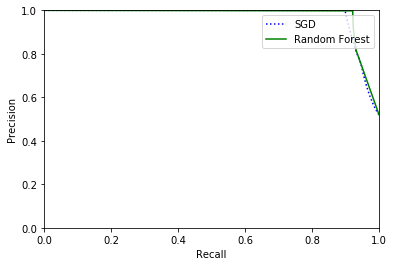

In [718]:
# calculate the precisions, recalls and thresholds to plot the tradeoff
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
forest_precisions, forest_recalls, thresholds = precision_recall_curve(y_train, y_scores_forest)

# plot precision vs recall
plt.plot(recalls, precisions, "b:", label="SGD")
plt.plot(forest_recalls, forest_precisions, "g-", label="Random Forest")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.legend(loc="upper right")
plt.show()

# Analyse Data

In [719]:
data_frame.sort_values(["values"], ascending=[True])

,labels,values
1000000,False,0
1000001,False,1
0,True,2
1,True,3
1000002,False,4
2,True,5
1000003,False,6
3,True,7
1000004,False,8
1000005,False,9


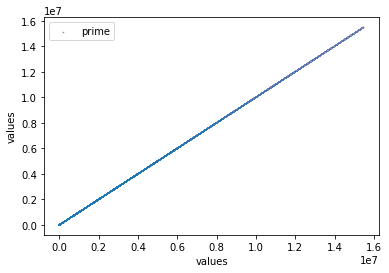

In [720]:
data_frame.plot(kind="scatter", x="values", y="values", alpha=0.8, s=data_frame["labels"]/data_frame["values"], label="prime")

In [721]:
from sklearn.neural_network import MLPClassifier

nn_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 100, 50, 20), random_state=42)
nn_clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 50, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [722]:
y_train_pred = cross_val_predict(nn_clf, X_train, y_train, cv=3)

confusion_matrix(y_train, y_train_pred)

array([[737201,      0],
       [800000,      0]])

In [725]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [743]:
forest_clf.predict([7])

/home/xpitfire/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ True], dtype=bool)